## Library Imports and installs 

In [2]:
%%capture
!pip install plotly -U

In [99]:
import pandas as pd
import numpy as np
import plotly
import time
import sys
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings('ignore')

The dataset contains 30k samples with the following features:

* customer: Anonymized customer's id.
* order: Order id, starting from zero.
* total_items : The number of items purchased in the order.
* discount% : The percent of total discount received. For instance, if the customer saves €20 in a €100 order (that is, he had to pay €80), this field will contain a 20. This field actually joins both discounts and recharges (like the sugar tax), so sometimes could be negative.
* weekday : Day of the week when the order was paid. 1=Monday, 7=Sunday.
* hour : The hour of the day the purchase was done. From 00 to 23. 
* Categories' partials : Percent of money spent in each of the 8 website's main categories:
** Food% : Non perishable food, for example: rice, cooking oil, snacks, cookies, sauces, canned food.
** Fresh% : Fresh and frozen food, for example: fresh tuna, fruits, frozen pizza, salads, meat.
** Drinks% : All kind of beverages, like: water, juices, wine, alcoholic drinks, milk, soy drinks.
** Home% : Products for home, from toilet paper to small appliances.
** Beauty% : Items for cleaning your body and makeup; for example: shampoo, shaving foam, cosmetics.
** Health% : Medicinal solutions that can be sold in Spain without medic prescription: diet pills, condoms, tooth paste.
** Baby% : Useful articles if you have a baby: diapers, baby food, baby care.
** Pets% : Items related with dogs, cats and other pets; like food, toys, sanitary sand.

## Data Description

In [100]:
df = pd.read_csv('data.csv')
categories = df.loc[:, ["Food%",	"Fresh%",	"Drinks%",	"Home%",	"Beauty%",	"Health%",	"Baby%",	"Pets%"]]


In [101]:
df.describe()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,5012.483367,14999.500000,31.739933,8.455495,3.642367,15.034667,23.560406,20.227279,23.349235,13.539575,5.892949,1.132959,11.096145,1.043087
std,2888.646245,8660.398374,20.576579,14.199350,2.122031,5.717052,21.719824,23.661767,22.523335,17.850282,13.996518,5.307620,24.740364,6.195390
min,0.000000,0.000000,1.000000,-65.150000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2541.750000,7499.750000,18.000000,1.177500,2.000000,11.000000,7.220000,0.000000,6.710000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5043.000000,14999.500000,29.000000,4.160000,3.000000,15.000000,19.650000,10.930000,17.890000,7.210000,0.000000,0.000000,0.000000,0.000000
75%,7483.000000,22499.250000,41.000000,9.990000,5.000000,20.000000,33.260000,35.790000,33.162500,20.002500,6.512500,0.000000,4.172500,0.000000
max,10238.000000,29999.000000,298.000000,100.000000,7.000000,23.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [102]:
heatmap_customer_count = pd.pivot_table(df, values='order', index='weekday', columns='hour', aggfunc='count')
fig = px.imshow(heatmap_customer_count)
fig.update_layout(title_text="Customer Count Heatmap")
fig.show()

In [103]:
heatmap_item_count = pd.pivot_table(df, values='total_items', index='weekday', columns='hour', aggfunc='sum')
fig = px.imshow(heatmap_item_count)
fig.update_layout(title_text="Item Sum Heatmap")
fig.show()

In [105]:
df2=df.drop(['customer','order','hour'],axis=1)
corr = df2.corr()
fig = px.imshow(corr)
fig.show()

In [106]:
count = df.customer.value_counts().reset_index()
fig = px.histogram(count, x="customer")
fig.update_layout(title_text="Customer Order Count Histogram")
fig.show()

In [107]:
fig = categories.describe().transpose().loc[:,['mean', 'std', '25%', '50%', '75%']].plot()
fig.update_layout(title_text="Categories Distribution")
fig.update_xaxes(title_text="Categories")
fig.update_yaxes(title_text="Value")
fig.show()

In [108]:
fig = ff.create_distplot([categories[c] for c in categories.columns], categories.columns, bin_size=0.2,show_curve=True, show_rug=False, histnorm='probability')
fig.update_xaxes(range=[0.2, 100])
fig.update_yaxes(range=[0, 0.008])
fig.update_layout(title_text="Categories Hitogram")
fig.show()

## Outlier Detection

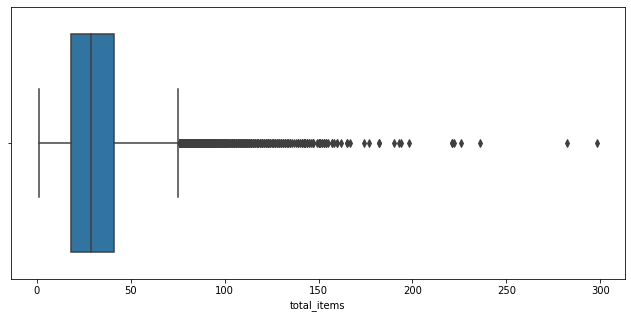

In [112]:
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(11,5))
sns.boxplot(df['total_items'])
plt.show()

In [113]:
Q1 = df['total_items'].quantile(0.25)
Q3 = df['total_items'].quantile(0.75)
iqr= Q3-Q1
upper= Q1 + 1.5 * iqr
lower= Q3 - 1.5 * iqr
df[df['total_items'] > upper]
df[df['total_items'] < lower]
df_new = df[df['total_items'] < upper]
df_new.shape

(26104, 14)

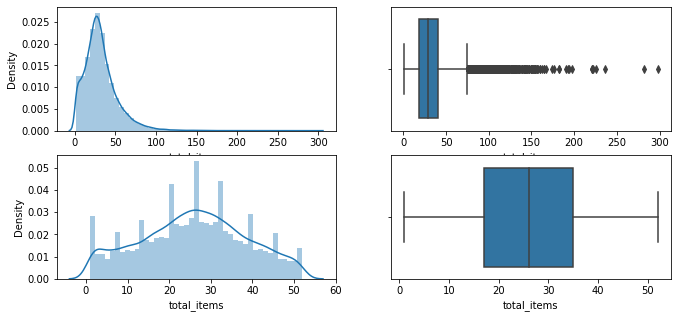

In [114]:
plt.figure(figsize=(11,5))
plt.subplot(2,2,1)
sns.distplot(df['total_items'])
plt.subplot(2,2,2)
sns.boxplot(df['total_items'])
plt.subplot(2,2,3)
sns.distplot(df_new['total_items'])
plt.subplot(2,2,4)
sns.boxplot(df_new['total_items'])
plt.show()

In [115]:
df=df_new

## PCA

In [116]:
pca1 = PCA(n_components=df.shape[1])
pca1.fit(df.values)
pd.Series(pca1.explained_variance_ratio_).plot()

In [117]:
pd.Series(pca1.components_[0]).plot()

In [118]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.describe()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
count,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000,26104.000000
mean,0.493234,0.503758,0.487836,0.443466,0.439530,0.651015,0.223577,0.192486,0.239543,0.136799,0.061231,0.011803,0.122179,0.010680
std,0.283886,0.290404,0.249074,0.077970,0.353883,0.247595,0.214985,0.238101,0.234266,0.185012,0.147871,0.055830,0.260709,0.065039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251099,0.251600,0.313725,0.400545,0.166667,0.478261,0.054900,0.000000,0.061100,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.498633,0.505500,0.490196,0.419195,0.333333,0.652174,0.181400,0.085500,0.181650,0.067000,0.000000,0.000000,0.000000,0.000000
75%,0.736765,0.757100,0.666667,0.455646,0.666667,0.869565,0.322925,0.338400,0.346300,0.203025,0.065325,0.000000,0.056500,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
pca12 = PCA(n_components=df_scaled.shape[1])
pca12.fit(df_scaled.values)
pd.Series(pca12.explained_variance_ratio_).plot()

In [15]:
pca2 = PCA(n_components=categories.shape[1])
pca2.fit(categories)
pd.Series(pca2.explained_variance_ratio_).plot()

## Kmeans

In [22]:
clusters = range(2,20)
kmeans_inertia = pd.Series(index=clusters)
kmeans_silhouette = pd.Series(index=clusters)
for n in clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(categories)
    kmeans_inertia.loc[n] = kmeans.inertia_
    kmeans_silhouette.loc[n] = silhouette_score(categories, kmeans.labels_)

In [23]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=list(clusters), y=kmeans_inertia, name="Inertia"),secondary_y=False)
fig.add_trace(go.Scatter(x=list(clusters), y=kmeans_silhouette, name="Silhouette"),secondary_y=True)
fig.update_layout(title_text="Kmeans Scores")
fig.update_xaxes(title_text="# of Clusters")

fig.update_yaxes(title_text="Inertia", secondary_y=False)
fig.update_yaxes(title_text="Silhouette", secondary_y=True)

fig.show()

In [25]:
from sklearn.metrics import davies_bouldin_score
clusters = range(2,20)
kmeans_davies = pd.Series(index=clusters)
kmeans_silhouette = pd.Series(index=clusters)
for n in clusters:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(categories)
    kmeans_davies.loc[n] = davies_bouldin_score(categories,  kmeans.fit_predict(categories))
    kmeans_silhouette.loc[n] = silhouette_score(categories, kmeans.labels_)


In [28]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=list(clusters), y=kmeans_davies, name="davies"),secondary_y=False)
fig.add_trace(go.Scatter(x=list(clusters), y=kmeans_silhouette, name="Silhouette"),secondary_y=True)
fig.update_layout(title_text="Kmeans Scores")
fig.update_xaxes(title_text="# of Clusters")

fig.update_yaxes(title_text="davies", secondary_y=False)
fig.update_yaxes(title_text="Silhouette", secondary_y=True)

fig.show()

In [29]:
Selected_num_of_clusters = 6
kmeans = KMeans(n_clusters=Selected_num_of_clusters, random_state=0)
kmeans.fit(categories)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=categories.columns)
cluster_centers.transpose().plot()

In [30]:
cluster_centers.plot()

In [32]:
categories['labels'] = kmeans.labels_
categories['total_items'] = df.total_items
categories['discount%'] = df["discount%"]
categories.groupby('labels')['total_items'].describe().plot()

## MeanShift

In [81]:
bandwidth = estimate_bandwidth(categories, quantile=0.2, n_samples=3000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(categories)
labels = ms.labels_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(categories, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(categories, labels))

number of estimated clusters : 4
Silhouette Coefficient: 0.303
Dacies Bouldin Coefficient: 0.887


In [35]:
ms_cluster_centers = pd.DataFrame(ms.cluster_centers_, columns=categories.columns)
ms_cluster_centers.transpose().plot()

In [36]:
ms_cluster_centers.plot()

## GMM

In [89]:
from numpy import unique
from numpy import where
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

In [ ]:
from sklearn.mixture import GaussianMixture
n_components = range(2, 12)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(categories)
        score.append((cov,n_comp,gmm.bic(categories)))
score

In [120]:
parameters=['full','tied','diag','spherical']
n_clusters=np.arange(1,10)
results_=pd.DataFrame(columns=['Covariance Type','Number of Cluster','Silhouette Score','Davies Bouldin Score'])
for i in parameters:
    for j in n_clusters:
        gmm_cluster=GaussianMixture(n_components=j,covariance_type=i,random_state=123)
        clusters=gmm_cluster.fit_predict(df)
        if len(np.unique(clusters))>=2:
            results_=results_.append({"Covariance Type":i,'Number of Cluster':j,"Silhouette Score":metrics.silhouette_score(df,clusters),
                                    'Davies Bouldin Score':metrics.davies_bouldin_score(df,clusters)}
                                   ,ignore_index=True)

In [80]:
results_.sort_values('Silhouette Score',ascending=False)[:5]

,Covariance Type,Number of Cluster,Silhouette Score,Davies Bouldin Score
24,spherical,2,0.626080,0.500988
8,tied,2,0.607651,0.502905
25,spherical,3,0.588771,0.501476
9,tied,3,0.575369,0.504516
26,spherical,4,0.571099,0.501174


In [ ]:
df['labels'] = ms.predict(categories)
df[df['labels']==0].head(10)

## Agglomerative Hierarchial

In [82]:
from sklearn.cluster import AgglomerativeClustering

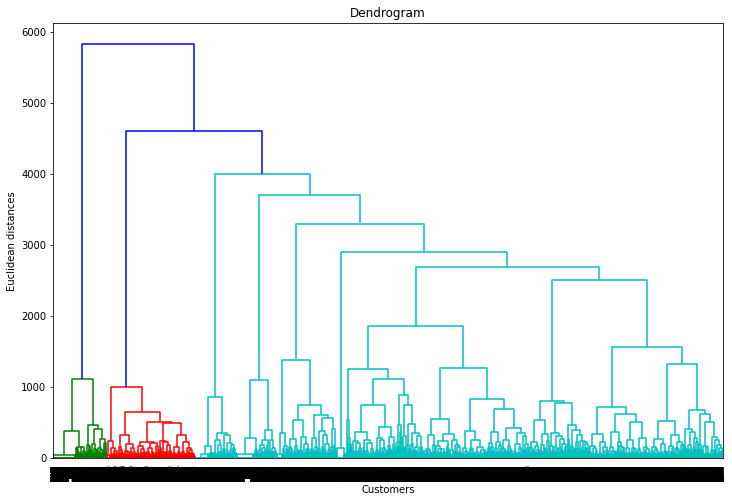

In [121]:
import scipy.cluster.hierarchy as sch 
plt.figure(figsize=(12,8)) 
dendrogram = sch.dendrogram(sch.linkage(categories, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [127]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
# define the model
Aggmodel = AgglomerativeClustering(n_clusters=3)
# fit model
ypred= Aggmodel.fit(categories)
ypred_2 = Aggmodel.fit_predict(categories)
# retrieve unique clusters
clusters = unique(ypred)
# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(categories, ypred.labels_, metric='euclidean')
print('Silhouette Score: %.4f' % score_AGclustering_s)

Silhouette Score: 0.2059


In [131]:
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(categories, ypred.labels_))

Davies Bouldin Coefficient: 0.966
